In [1]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=8b7999e0272be5eb853e17b9eaae1aa47f8cc325d6571ee8427038b4f89d457d
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.5 MB/s eta 0:00:00


In [2]:
from qiskit_aer import Aer
backend  = Aer.get_backend("qasm_simulator")
backend

QasmSimulator('qasm_simulator')

In [3]:
from qiskit import QuantumCircuit,transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import qiskit_aer
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator,  MCXGate
import numpy as np

{'001': 120, '100': 132, '110': 122, '101': 119, '000': 141, '010': 140, '111': 131, '011': 119}


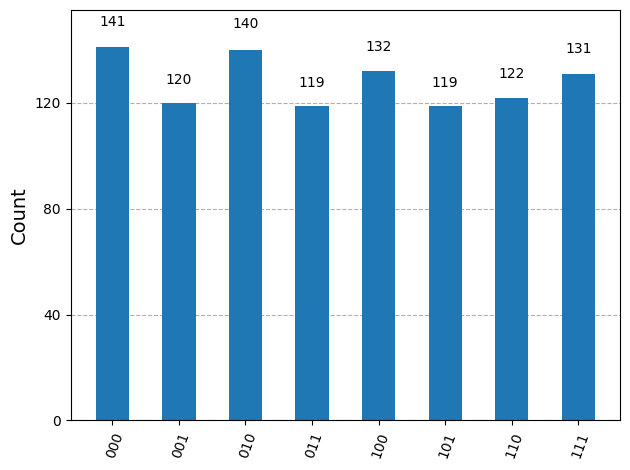

In [12]:
def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):

        circuit.cp(np.pi/2**(n-qubit), qubit, n)
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def qft(n):

    qc = QuantumCircuit(n)
    for i in range(n, 0, -1):
        qft_rotations(qc, i)
    swap_registers(qc, n)
    return qc

qc = qft(3)
qc.measure_all()
qc.draw("mpl")
qc_t  =transpile(qc,backend)
job = backend.run(qc_t,shot = 1024)
job_result = job.result()
counts = job_result.get_counts()
hist = plot_histogram(counts)
print(counts)
hist

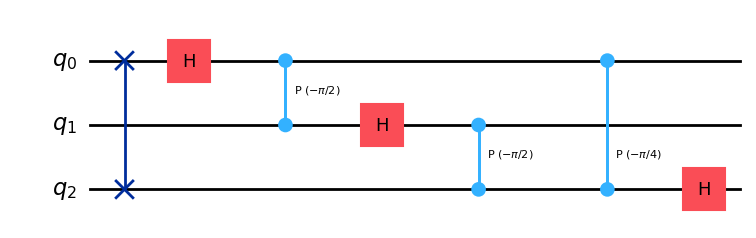

In [5]:
qc_i = qft(3)
iqft_qc = qc_i.inverse()
iqft_qc.draw("mpl")

{'001': 126, '111': 112, '011': 142, '110': 144, '100': 114, '010': 112, '000': 143, '101': 131}


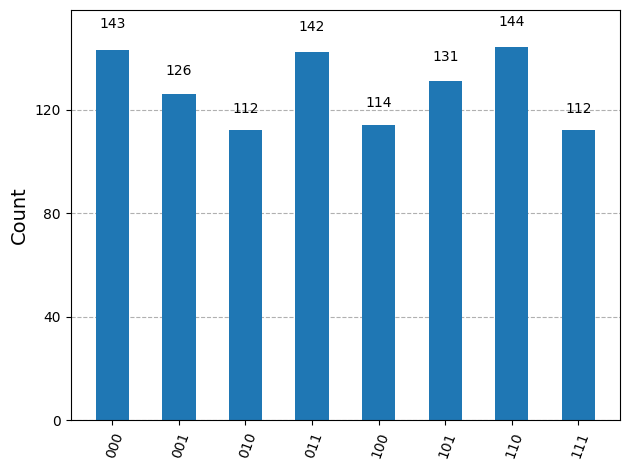

In [6]:
iqft_qc.measure_all()
qc_t  =transpile(iqft_qc,backend)
job = backend.run(qc_t,shot = 1024)
job_result = job.result()
counts = job_result.get_counts()
hist = plot_histogram(counts)
print(counts)
hist

In [25]:
from qiskit.circuit.library import QFT

def qpe_circuit(num_counting_qubits, theta):

    t = num_counting_qubits
    n = 1
    qc = QuantumCircuit(t + n, t)
    qc.x(t)
    qc.barrier()

    for qubit in range(t):
        qc.h(qubit)
    qc.barrier()

    for k in range(t):

        control_qubit = k
        target_qubit = t
        angle = theta * (2**k)

        qc.cp(angle, control_qubit, target_qubit)
    qc.barrier()

    iqft_gate = QFT(num_qubits=t, inverse=True, do_swaps=True).to_gate()

    qc.append(iqft_gate, range(t))
    qc.barrier()
    qc.measure(range(t), range(t))

    return qc



NUM_COUNTING_QUBITS = 3
THETA = np.pi / 4


qpe_c = qpe_circuit(NUM_COUNTING_QUBITS, THETA)

/tmp/ipython-input-681750870.py:24: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(num_qubits=t, inverse=True, do_swaps=True).to_gate()


{'001': 1024}


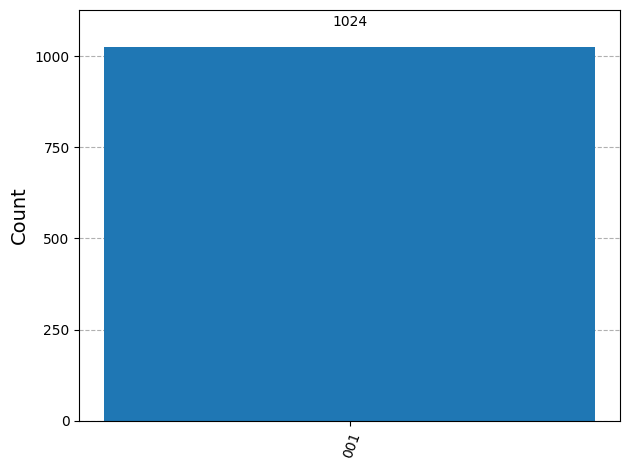

In [22]:
qc_t  =transpile(qpe_c,backend)
job = backend.run(qc_t,shot = 1024)
job_result = job.result()
counts = job_result.get_counts()
hist = plot_histogram(counts)
print(counts)
hist

In [23]:
max_ele = max(counts, key=counts.get)
m = int(max_ele, 2)

phi_estimated = m / (np.pow(2,NUM_COUNTING_QUBITS))
theta_estimated = phi_estimated * 2 * np.pi
print(f"Most likely measurement: |{max_ele}> which is the integer m = {m}")
print(f"Number of counting qubits (t): {NUM_COUNTING_QUBITS}")
print(f"Estimated phase (phi = m/2^t): {phi_estimated}")
print(f"Estimated angle (theta = phi*2*pi): {theta_estimated / np.pi:.3f} * pi")
print(f"Actual angle: {THETA / np.pi:.3f} * pi")


Most likely measurement: |001> which is the integer m = 1
Number of counting qubits (t): 3
Estimated phase (phi = m/2^t): 0.125
Estimated angle (theta = phi*2*pi): 0.250 * pi
Actual angle: 0.250 * pi


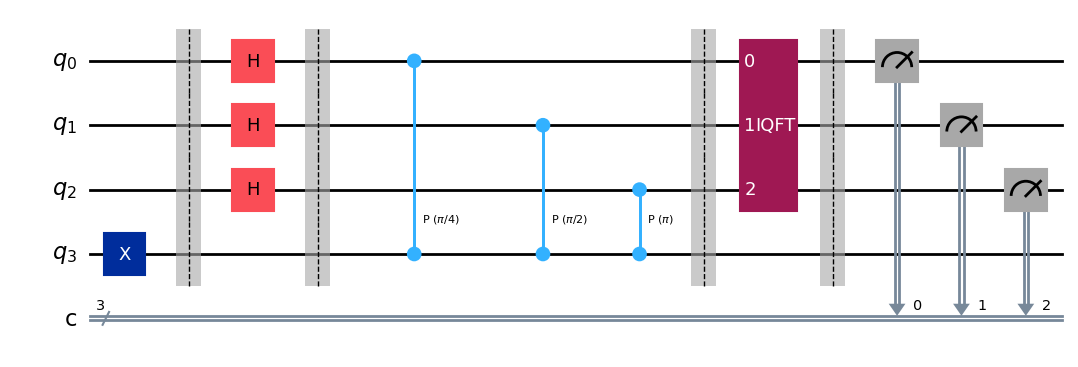

In [24]:
qpe_c.draw("mpl")